In [1]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn

# PyTorch Forecasting imports
from pytorch_forecasting import TimeSeriesDataSet, Baseline
from pytorch_forecasting.models.base_model import BaseModelWithCovariates
from pytorch_forecasting.models.nn import MultiEmbedding

# Lightning module for training
import lightning.pytorch as pl

import warnings
warnings.filterwarnings("ignore")

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch.tuner import Tuner
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

from pytorch_forecasting.metrics import MAE, SMAPE



In [2]:

# Set seed for reproducibility
np.random.seed(42)
pl.seed_everything(42)

# Create synthetic data
n_series = 2
n_steps = 1000
series_ids = np.array(list("AB"))

time_idx = np.tile(np.arange(n_steps), n_series)
series_id = np.repeat(series_ids, n_steps)
targets = []
cov1 = []
cov2 = []

for s in range(n_series):
    phase = np.random.rand() * 2 * np.pi
    amplitude = np.random.uniform(0.5, 1.5)
    base_series = amplitude * np.sin(0.2 * np.arange(n_steps) + phase) + s * 0.5
    noise = np.random.normal(scale=0.1, size=n_steps)
    target_series = base_series + noise
    
    cov1_series = target_series + np.random.normal(scale=0.2, size=n_steps)
    cov2_series = np.linspace(0, 1, n_steps) + np.random.normal(scale=0.1, size=n_steps)

    targets.extend(target_series)
    cov1.extend(cov1_series)
    cov2.extend(cov2_series)

# The covirants are defined as follows: variables in addition to the target variable itself that hold information about the target
# If your time series are related to each other (e.g. all sales of products of the same company), a model that can learn relations between the timeseries can improve accuracy. Not that only models that can process covariates can learn relationships between different timeseries.
# In this example we have two synthetic covariates:
data = pd.DataFrame({
    "series_id": series_id,
    "time_idx": time_idx,
    "target_value": targets,
    "covariate_1": cov1,
    "covariate_2": cov2,
})

print("Data shape:", data.shape)
print("Data sample:")
print(data.head())  

Global seed set to 42


Data shape: (2000, 5)
Data sample:
  series_id  time_idx  target_value  covariate_1  covariate_2
0         A         0      1.093539     1.105465    -0.079242
1         A         1      0.957359     0.827971    -0.029795
2         A         2      0.525831     0.665476    -0.187359
3         A         3      0.248127     0.326824     0.024332
4         A         4      0.140930     0.319969     0.004125


Example of how the encoder and decoder determine the numb of samples: \
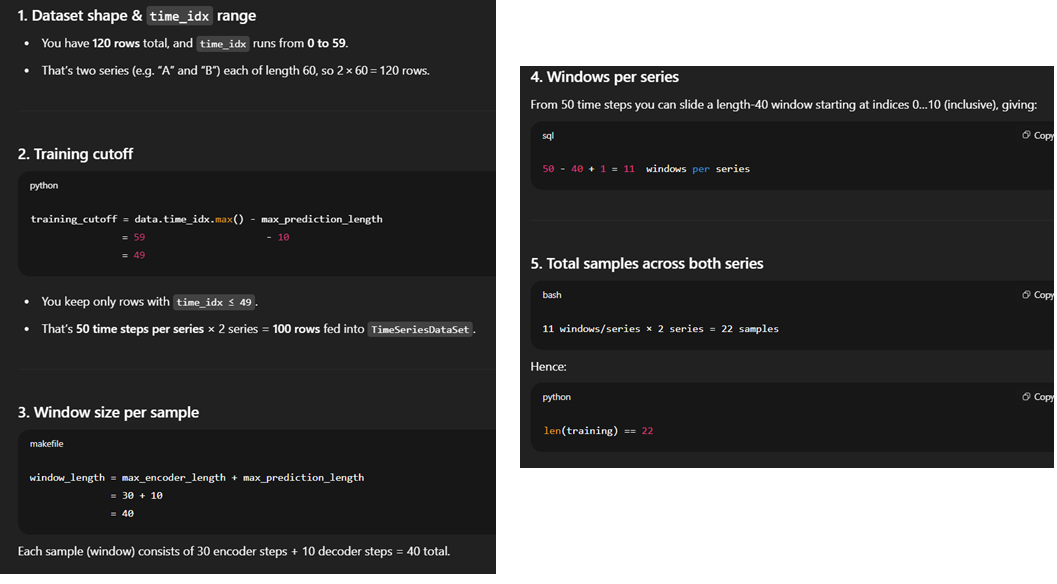

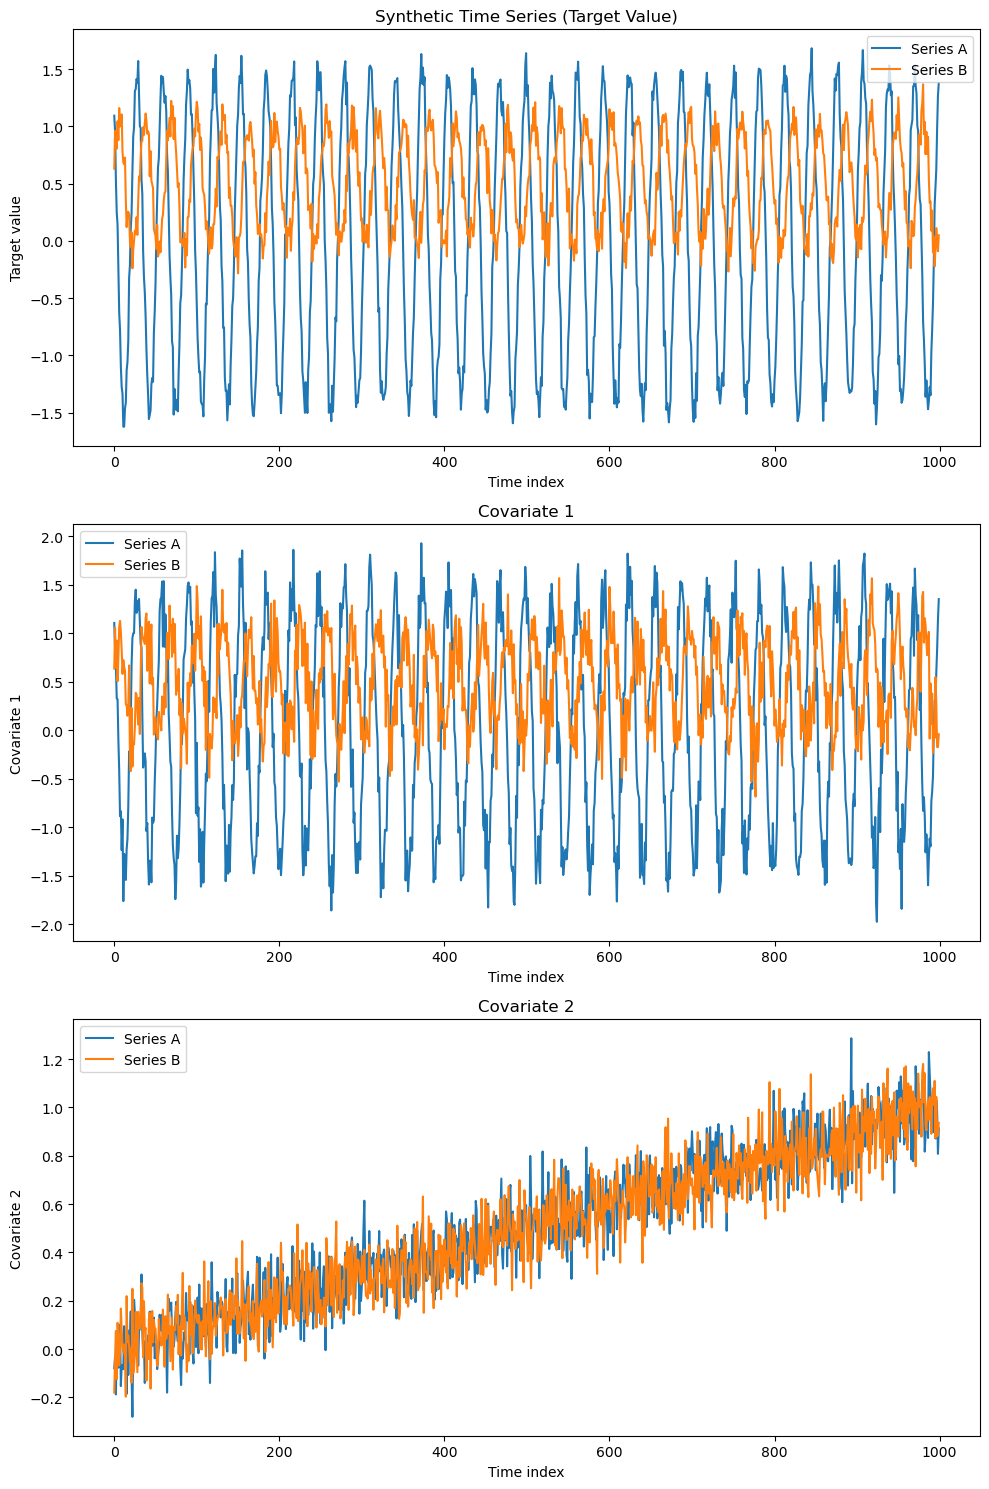

In [3]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot target values
for sid, df_grp in data.groupby('series_id'):
    axs[0].plot(df_grp['time_idx'], df_grp['target_value'], label=f"Series {sid}")
axs[0].set_title("Synthetic Time Series (Target Value)")
axs[0].set_xlabel("Time index")
axs[0].set_ylabel("Target value")
axs[0].legend()

# Plot covariate 1
for sid, df_grp in data.groupby('series_id'):
    axs[1].plot(df_grp['time_idx'], df_grp['covariate_1'], label=f"Series {sid}")
axs[1].set_title("Covariate 1")
axs[1].set_xlabel("Time index")
axs[1].set_ylabel("Covariate 1")
axs[1].legend()

# Plot covariate 2
for sid, df_grp in data.groupby('series_id'):
    axs[2].plot(df_grp['time_idx'], df_grp['covariate_2'], label=f"Series {sid}")
axs[2].set_title("Covariate 2")
axs[2].set_xlabel("Time index")
axs[2].set_ylabel("Covariate 2")
axs[2].legend()

plt.tight_layout()
plt.show()

# Dataset configuration
max_encoder_length = 100
max_prediction_length = 10
training_cutoff = data["time_idx"].max() - max_prediction_length

# Create training dataset
training = TimeSeriesDataSet(
    data[data.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="target_value",
    group_ids=["series_id"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=["time_idx", "covariate_1", "covariate_2"],
    time_varying_unknown_reals=["target_value"],
)

# Create validation dataset
validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)

batch_size = 64
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)


In [4]:
# Testing the TimeSeriesDataSet Dataloader and Understanding Data Structure
# This cell explores how PyTorch Forecasting structures time series data for model training

print("=" * 60)
print("TIMESERIESDATASET DATALOADER STRUCTURE ANALYSIS")
print("=" * 60)

# First, let's examine the training dataset parameters
print("\n1. TRAINING DATASET PARAMETERS:")
print("-" * 40)
dataset_params = training.get_parameters()
for key, value in dataset_params.items():
    print(f"{key}: {value}")

print(f"\nDataset length: {len(training)} samples")
print(f"Batch size: {batch_size}")
print(f"Number of batches in training dataloader: {len(train_dataloader)}")

# Sample a batch from the training dataloader
print("\n2. SAMPLING A BATCH FROM TRAINING DATALOADER:")
print("-" * 50)

# Get the first batch
x, y = next(iter(train_dataloader))

print("Batch structure:")
print(f"x (input dict) has {len(x)} keys")
print(f"y (target tuple) has {len(y)} elements")

print("\n3. DETAILED INPUT STRUCTURE (x):")
print("-" * 40)

# Analyze each component of the input dictionary x
for key, tensor in x.items():
    print(f"\n{key}:")
    print(f"  Shape: {tensor.shape}")
    print(f"  Data type: {tensor.dtype}")
    print(f"  Description:")
    
    if key == "encoder_cat":
        print("    - Categorical features for the encoder (historical period)")
        print("    - Shape: [batch_size, encoder_length, n_categorical_features]")
        print("    - Contains encoded categorical variables like series_id")
        if tensor.numel() > 0:
            print(f"    - Sample values: {tensor[0, :3, :] if tensor.shape[1] >= 3 else tensor[0]}")
    
    elif key == "encoder_cont":
        print("    - Continuous features for the encoder (historical period)")
        print(f"    - Shape: [batch_size={tensor.shape[0]}, encoder_length={tensor.shape[1]}, n_features={tensor.shape[2]}]")
        print("    - Contains scaled continuous variables and covariates")
        print(f"    - Sample values (first sample, first 3 timesteps):")
        if tensor.shape[1] >= 3:
            print(f"      {tensor[0, :3, :].numpy()}")
        else:
            print(f"      {tensor[0].numpy()}")
    
    elif key == "encoder_target":
        print("    - Target values for the encoder (historical period)")
        print(f"    - Shape: [batch_size={tensor.shape[0]}, encoder_length={tensor.shape[1]}]")
        print("    - Contains actual target values (unscaled) that the model sees as history")
        print(f"    - Sample values (first sample): {tensor[0, :5].numpy() if tensor.shape[1] >= 5 else tensor[0].numpy()}")
    
    elif key == "encoder_lengths":
        print("    - Actual lengths of encoder sequences (for variable-length sequences)")
        print("    - Shape: [batch_size]")
        print(f"    - Values: {tensor.numpy()}")
    
    elif key == "decoder_cat":
        print("    - Categorical features for the decoder (prediction period)")
        print(f"    - Shape: [batch_size={tensor.shape[0]}, decoder_length={tensor.shape[1]}, n_features={tensor.shape[2]}]")
        print("    - Known categorical features during prediction period")
    
    elif key == "decoder_cont":
        print("    - Continuous features for the decoder (prediction period)")
        print(f"    - Shape: [batch_size={tensor.shape[0]}, decoder_length={tensor.shape[1]}, n_features={tensor.shape[2]}]")
        print("    - Known continuous features during prediction period (e.g., time_idx, covariates)")
        print(f"    - Sample values (first sample):")
        print(f"      {tensor[0].numpy()}")
    
    elif key == "decoder_target":
        print("    - Target values for the decoder (what we want to predict)")
        print(f"    - Shape: [batch_size={tensor.shape[0]}, decoder_length={tensor.shape[1]}]")
        print("    - These are the 'ground truth' values for the prediction period")
        print(f"    - Sample values (first sample): {tensor[0].numpy()}")
    
    elif key == "decoder_lengths":
        print("    - Actual lengths of decoder sequences")
        print("    - Shape: [batch_size]")
        print(f"    - Values: {tensor.numpy()}")
    
    elif key == "decoder_time_idx":
        print("    - Time indices for the decoder period")
        print(f"    - Shape: [batch_size={tensor.shape[0]}, decoder_length={tensor.shape[1]}]")
        print("    - Shows which time steps we're predicting")
        print(f"    - Sample values (first sample): {tensor[0].numpy()}")
    
    elif key == "groups":
        print("    - Group identifiers (encoded series_id)")
        print("    - Shape: [batch_size, n_group_ids]")
        print("    - Identifies which time series each sample belongs to")
        print(f"    - Sample values: {tensor[:5].numpy()}")  # Show first 5 samples
    
    elif key == "target_scale":
        print("    - Scaling parameters for target denormalization")
        print("    - Shape: [batch_size, 2] - typically [mean, std] for each sample")
        print("    - Used to transform predictions back to original scale")
        print(f"    - Sample values (first sample): {tensor[0].numpy()}")

print("\n4. TARGET STRUCTURE (y):")
print("-" * 30)

target, weight = y
print(f"Target shape: {target.shape}")
print(f"Target dtype: {target.dtype}")
print(f"Weight: {weight}")  # Usually None unless using sample weights

print("\nTarget explanation:")
print("- Shape: [batch_size, prediction_length]")
print("- Contains the actual target values we want to predict")
print("- Same as decoder_target in the input dict x")
print(f"- Sample target values (first sample): {target[0].numpy()}")

print("\n5. RELATIONSHIP BETWEEN ENCODER AND DECODER:")
print("-" * 50)

# Show how encoder and decoder connect in time
sample_idx = 0  # Look at first sample in batch
encoder_length = x["encoder_lengths"][sample_idx].item()
decoder_length = x["decoder_lengths"][sample_idx].item()

print(f"Sample {sample_idx} analysis:")
print(f"- Encoder length: {encoder_length} time steps")
print(f"- Decoder length: {decoder_length} time steps")
print(f"- Group ID: {x['groups'][sample_idx].item()}")

# Show the time progression
if "decoder_time_idx" in x:
    last_encoder_time = x["decoder_time_idx"][sample_idx][0].item() - 1
    decoder_times = x["decoder_time_idx"][sample_idx].numpy()
    print(f"- Last encoder time index: {last_encoder_time}")
    print(f"- Decoder time indices: {decoder_times}")
    print(f"- Time gap: {decoder_times[0] - last_encoder_time - 1} (should be 0 for continuous prediction)")

print("\n6. PRACTICAL EXAMPLE - HOW MODEL USES THIS DATA:")
print("-" * 55)

print("For a forecasting model:")
print("1. Encoder processes historical data:")
print(f"   - Uses encoder_cont (covariates): shape {x['encoder_cont'].shape}")
print(f"   - Uses encoder_target (past values): shape {x['encoder_target'].shape}")
print(f"   - May use encoder_cat (categorical features): shape {x['encoder_cat'].shape}")

print("\n2. Decoder generates predictions:")
print(f"   - Uses decoder_cont (known future covariates): shape {x['decoder_cont'].shape}")
print(f"   - May use decoder_cat (known future categorical): shape {x['decoder_cat'].shape}")
print(f"   - Outputs predictions for decoder_target: shape {target.shape}")

print("\n3. Loss calculation:")
print("   - Compare model predictions with y[0] (target)")
print("   - Use target_scale to denormalize if needed")

print("\n7. FEATURE BREAKDOWN:")
print("-" * 25)

# Analyze what features are being used
static_cats = dataset_params.get("static_categoricals") or []
known_cats = dataset_params.get("time_varying_known_categoricals") or []
print(f"Categorical features: {static_cats + known_cats}")
print(f"Known real features: {dataset_params['time_varying_known_reals']}")
print(f"Unknown real features: {dataset_params['time_varying_unknown_reals']}")

print(f"\nContinuous feature dimensions in encoder: {x['encoder_cont'].shape[-1]}")
print(f"Continuous feature dimensions in decoder: {x['decoder_cont'].shape[-1]}")

# If we have continuous features, show what they likely represent
if x['encoder_cont'].shape[-1] > 0:
    print(f"\nEncoder continuous features likely include:")
    known_reals = dataset_params['time_varying_known_reals']
    print(f"We have {x['encoder_cont'].shape[-1]} continuous features:")
    
    # The 4th feature is likely the target_value that gets added automatically
    expected_features = known_reals + ['target_value']  # PyTorch Forecasting often adds target as a feature
    for i in range(x['encoder_cont'].shape[-1]):
        if i < len(expected_features):
            print(f"  - Feature {i}: {expected_features[i]}")
        else:
            print(f"  - Feature {i}: Unknown feature")

print("\n" + "=" * 60)
print("SUMMARY: This dataloader provides structured time series data where:")
print("- Encoder data = Historical context (what the model learns from)")
print("- Decoder data = Future period (what the model predicts)")
print("- All tensors are properly batched and ready for model training")
print("=" * 60)

TIMESERIESDATASET DATALOADER STRUCTURE ANALYSIS

1. TRAINING DATASET PARAMETERS:
----------------------------------------
time_idx: time_idx
target: target_value
group_ids: ['series_id']
weight: None
max_encoder_length: 100
min_encoder_length: 100
min_prediction_idx: 0
min_prediction_length: 10
max_prediction_length: 10
static_categoricals: None
static_reals: None
time_varying_known_categoricals: None
time_varying_known_reals: ['time_idx', 'covariate_1', 'covariate_2']
time_varying_unknown_categoricals: None
time_varying_unknown_reals: ['target_value']
variable_groups: None
constant_fill_strategy: None
allow_missing_timesteps: False
lags: None
add_relative_time_idx: False
add_target_scales: False
add_encoder_length: False
target_normalizer: EncoderNormalizer(
	method='standard',
	center=True,
	max_length=None,
	transformation=None,
	method_kwargs={}
)
categorical_encoders: {'__group_id__series_id': NaNLabelEncoder(add_nan=False, warn=True)}
scalers: {'time_idx': StandardScaler(), 'cova

The dataloader outputs tuple(X,y) and here are componets of x which is dict of tensors and y which is also dic : \
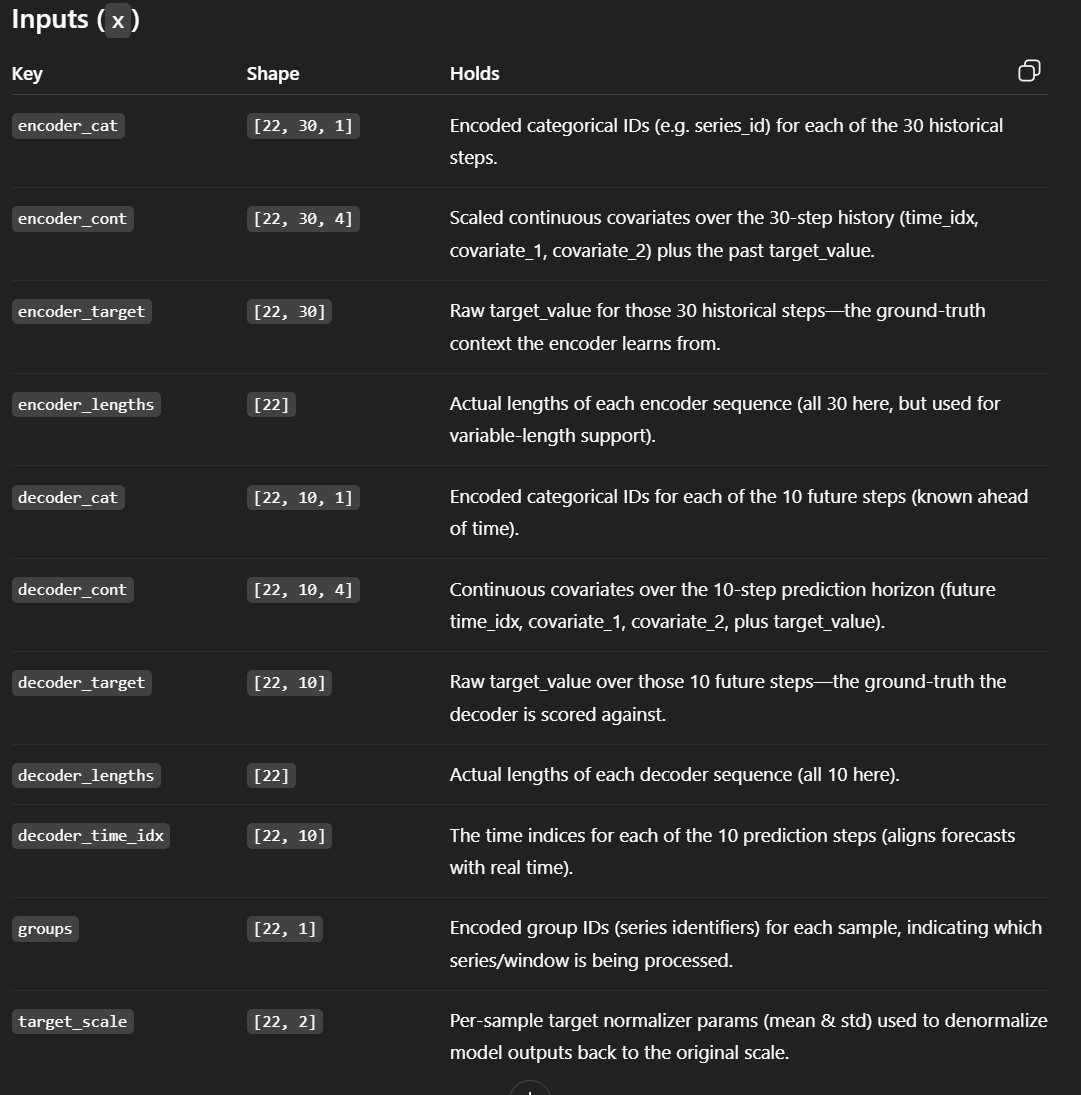
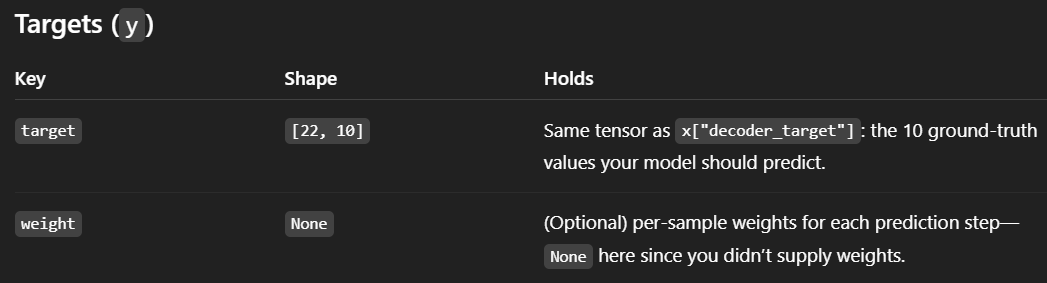

In [5]:
# Calculate baseline error
baseline_predictions = Baseline().predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
baseline_smape = SMAPE()(baseline_predictions.output, baseline_predictions.y)
print(f"Baseline SMAPE: {baseline_smape:.4f}")

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Baseline SMAPE: 1.5402


In [6]:


class CustomTransformerWithCovariates(BaseModelWithCovariates):
    """
    Custom Transformer model for PyTorch Forecasting:
    • Uses encoder data to create context via Transformer
    • Predicts full horizon at once with linear head
    • Compatible with categorical and continuous variables
    """

    def __init__(
        self,
        hidden_size: int = 128,
        n_heads: int = 4,
        n_layers: int = 2,
        dropout: float = 0.1,
        **kwargs,
    ):
        # Store all hyperparameters for PTF serialization
        self.save_hyperparameters()
        
        # Filter out covariate-related kwargs that BaseModel doesn't accept
        base_kwargs = {k: v for k, v in kwargs.items() 
                      if k not in {'static_categoricals', 'static_reals', 
                                  'time_varying_categoricals_encoder', 'time_varying_categoricals_decoder',
                                  'time_varying_reals_encoder', 'time_varying_reals_decoder',
                                  'x_reals', 'x_categoricals', 'embedding_sizes', 'embedding_labels',
                                  'embedding_paddings', 'categorical_groups'}}
        
        # Initialize parent class
        super().__init__(**base_kwargs)

        # Get prediction horizon from dataset parameters
        self.pred_len = self.hparams.dataset_parameters["max_prediction_length"]

        # Debug prints to understand the data structure
        print("=" * 50)
        print("Model initialization")
        print("=" * 50)
        print(f"embedding_sizes: {self.hparams.embedding_sizes}")
        print(f"embedding_paddings: {self.hparams.embedding_paddings}")
        print(f"x_categoricals: {self.hparams.x_categoricals}")
        print(f"x_reals: {self.hparams.x_reals}")
        print(f"dataset_parameters keys: {list(self.hparams.dataset_parameters.keys())}")

        cont_dim = len(self.hparams.x_reals)  # continuous encoder features
        print(f"cont_dim: {cont_dim} (type: {type(cont_dim)})")
        print(f"x_reals content: {self.hparams.x_reals}")
        
            
        total_dim = cont_dim
        print(f"total input dimension: {total_dim}")
        print("=" * 50)
        
        # Input projection layer
        self.input_proj = nn.Linear(total_dim, hidden_size)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size,
            nhead=n_heads,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
        # Output head - predict full horizon
        self.head = nn.Linear(hidden_size, self.pred_len)

    def forward(self, x):
        """
        Forward pass using encoder data only.
        
        Args:
            x: Dictionary from TimeSeriesDataSet dataloader
            
        Returns:
            NetworkOutput with predictions
        """
        batch_size, seq_len = x["encoder_cont"].shape[:2]
        cat_emb = x["encoder_cont"].new_empty(batch_size, seq_len, 0)
        
        # Concatenate continuous and categorical features
        encoder_input = torch.cat([x["encoder_cont"], cat_emb], dim=-1)  # [B, T, total_dim]
        
        # Project to hidden dimension
        h = self.input_proj(encoder_input)  # [B, T, hidden_size]
        
        # Apply transformer and mean pool over time
        h = self.transformer(h)  # [B, T, hidden_size]
        h = h.mean(dim=1)  # [B, hidden_size] - average over time steps
        
        # Generate predictions for full horizon
        predictions = self.head(h)  # [B, pred_len]
        
        # Transform output (handles scaling, etc.)
        predictions = self.transform_output(predictions, target_scale=x["target_scale"])
        
        # Return in PTF expected format
        return self.to_network_output(prediction=predictions)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Model initialization
embedding_sizes: {}
embedding_paddings: []
x_categoricals: []
x_reals: ['time_idx', 'covariate_1', 'covariate_2', 'target_value']
dataset_parameters keys: ['time_idx', 'target', 'group_ids', 'weight', 'max_encoder_length', 'min_encoder_length', 'min_prediction_idx', 'min_prediction_length', 'max_prediction_length', 'static_categoricals', 'static_reals', 'time_varying_known_categoricals', 'time_varying_known_reals', 'time_varying_unknown_categoricals', 'time_varying_unknown_reals', 'variable_groups', 'constant_fill_strategy', 'allow_missing_timesteps', 'lags', 'add_relative_time_idx', 'add_target_scales', 'add_encoder_length', 'target_normalizer', 'categorical_encoders', 'scalers', 'randomize_length', 'predict_mode']
cont_dim: 4 (type: <class 'int'>)
x_reals content: ['time_idx', 'covariate_1', 'covariate_2', 'target_value']
total input dimension: 4


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.02089296130854039
Restoring states from the checkpoint path at d:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\notebooks\.lr_find_c19232ec-ad43-4d45-88b6-481027fd663b.ckpt
Restored all states from the checkpoint at d:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\notebooks\.lr_find_c19232ec-ad43-4d45-88b6-481027fd663b.ckpt


Suggested learning rate: 0.02089296130854039


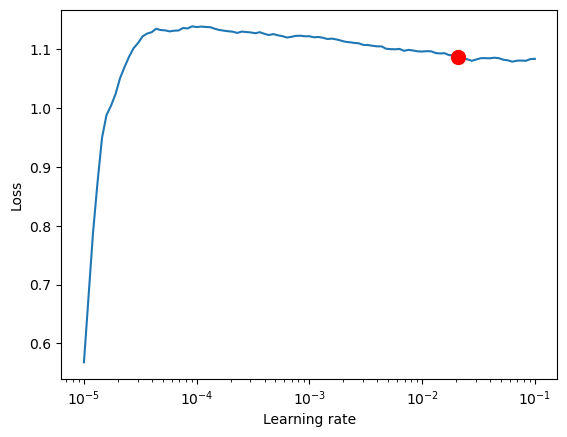

In [7]:

# Instantiate and train the model
model = CustomTransformerWithCovariates.from_dataset(
    training,
    hidden_size=32,
    n_heads=4,
    n_layers=1,
    dropout=0.1,
    learning_rate=1e-3,
)

# Learning rate finder
trainer = pl.Trainer(accelerator="gpu", gradient_clip_val=0.1)
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-5,
    max_lr=1e-1,
)

suggested_lr = lr_finder.suggestion()
print(f"Suggested learning rate: {suggested_lr}")
fig = lr_finder.plot(show=True, suggest=True)
fig.show()

In [8]:

# Train model with early stopping
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")

trainer = pl.Trainer(
    max_epochs=2000,
    accelerator="cuda",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    enable_checkpointing=True,
)


trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type               | Params
-------------------------------------------------------
0 | loss            | SMAPE              | 0     
1 | logging_metrics | ModuleList         | 0     
2 | input_proj      | Linear             | 160   
3 | transformer     | TransformerEncoder | 137 K 
4 | head            | Linear             | 330   
-------------------------------------------------------
137 K     Trainable params
0         Non-trainable params
137 K     Total params
0.552     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Model initialization
embedding_sizes: {}
embedding_paddings: []
x_categoricals: []
x_reals: ['time_idx', 'covariate_1', 'covariate_2', 'target_value']
dataset_parameters keys: ['time_idx', 'target', 'group_ids', 'weight', 'max_encoder_length', 'min_encoder_length', 'min_prediction_idx', 'min_prediction_length', 'max_prediction_length', 'static_categoricals', 'static_reals', 'time_varying_known_categoricals', 'time_varying_known_reals', 'time_varying_unknown_categoricals', 'time_varying_unknown_reals', 'variable_groups', 'constant_fill_strategy', 'allow_missing_timesteps', 'lags', 'add_relative_time_idx', 'add_target_scales', 'add_encoder_length', 'target_normalizer', 'categorical_encoders', 'scalers', 'randomize_length', 'predict_mode']
cont_dim: 4 (type: <class 'int'>)
x_reals content: ['time_idx', 'covariate_1', 'covariate_2', 'target_value']
total input dimension: 4
Model MAE: 0.7561


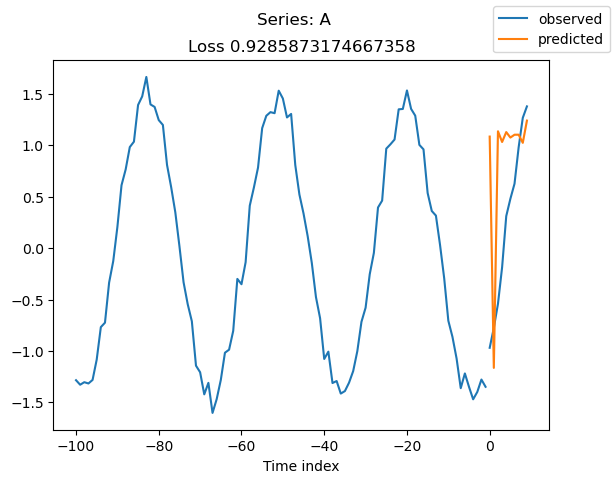

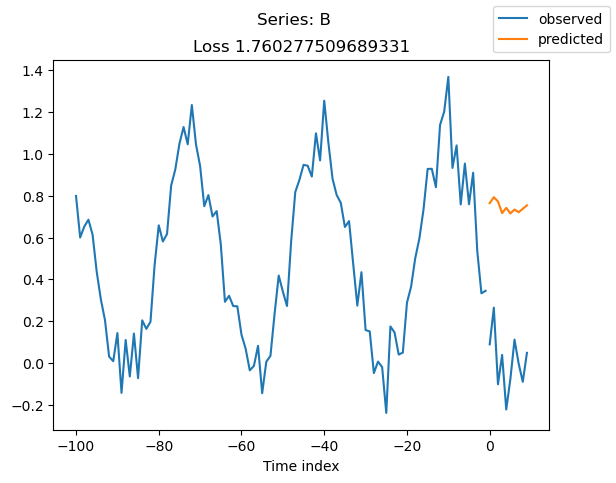

IndexError: index 2 is out of bounds for dimension 0 with size 2

In [9]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = CustomTransformerWithCovariates.load_from_checkpoint(best_model_path)

predictions = best_model.predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
model_mae = MAE()(predictions.output, predictions.y)
print(f"Model MAE: {model_mae:.4f}")

# Generate raw predictions for visualization
raw_predictions = best_model.predict(
    val_dataloader, mode="raw", return_x=True, trainer_kwargs=dict(accelerator="cpu")
)

# Visualization
series_index = validation.x_to_index(raw_predictions.x)["series_id"]
n_plots = min(4, len(raw_predictions.x))

for idx in range(n_plots):
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)
    plt.suptitle(f"Series: {series_index.iloc[idx]}")
    plt.show()